# Langevin
First we do simulations for tracking models, starting with Langevin model, where we have
$a_j = \begin{bmatrix} 0 & 1 \\ 0 & -\lambda \end{bmatrix}$ and
$h_j = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$

Because there is no $B$ terms, $M(\Delta t) = 0$. To calculate the mean and variance, we start with the result

$\text{exp}(\begin{bmatrix} 0 & 1 \\ 0 & -\lambda \end{bmatrix} t) = 
\begin{bmatrix} 1 & -\frac{1}{\lambda}(e^{-t \lambda}-1) \\
0 & e^{-t \lambda} \end{bmatrix}$

After calculation we get

$q_i = \begin{bmatrix} 0 & \frac{1}{2 \lambda^2}+\frac{1}{2 \lambda^2} e^{-2 \Delta t \lambda}+\frac{1}{\lambda^2}(1-e^{-\Delta t \lambda}) \\
0 & \frac{1}{2 \lambda} (1-e^{-2 \Delta t \lambda}) \end{bmatrix}$

$f_i(\Delta t, V_i) = \begin{bmatrix} -\frac{1}{\lambda} e^{(V_i-\Delta t)\lambda}+\frac{1}{\lambda} \\
e^{(V_i-\Delta t)\lambda} \end{bmatrix}$

$\int_0^{\Delta t} f(\Delta t, u) du = \begin{bmatrix} -\frac{1}{\lambda^2} (1-e^{-\Delta t \lambda})+\frac{\Delta t}{\lambda} \\
\frac{1}{\lambda}(1-e^{-\Delta t \lambda}) \end{bmatrix}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sf
from scipy import stats

C:\Users\surface\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\surface\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\surface\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
l = 1
# c = 20
N = 100
delta_t = 1
sigma_w = 0.2
mu_w = 0.01
alpha = 0.6

# convert variables
C = alpha*2**alpha/(sf.gamma(1-alpha))
r = 1.35 # from generalised shot noise paper
episilon = 1e-3
c = C*episilon**(-alpha)/alpha/delta_t
beta = 0.5*r**(1/alpha)

# calculate first/second moment of residuals
M_z1 = 2**(1-alpha)*r**(1-1/alpha)*C*sf.gamma(1-alpha)*sf.gammainc(1-alpha, 0.5*r**(1/alpha)*episilon)
M_z2 = C*sf.gamma(2-alpha)*2**(2-alpha)*r**(1-2/alpha)*sf.gammainc(2-alpha, 0.5*r**(1/alpha)*episilon)

In [3]:
print(M_z1, M_z2, c)

0.06465679618051282 1.846883766134736e-05 43.11468498654165


In [4]:
# function to generate tempered stable process jumps
def TS_subordinator_jumps(delta_t):
    gamma = 0
    sum_n = 0
    mean_n = 0
    while gamma<c*delta_t:
        delta_gamma = np.random.exponential(scale = 1.0)
        gamma = gamma+delta_gamma
         
        while True:
            z_i = (alpha*gamma/C)**(-1/alpha)
            p_xi = np.exp(-beta*z_i) # accept with probability, because it's tempered
            u_i = np.random.uniform()
            if u_i>p_xi:
                break
        
        v_i = np.random.uniform(0,delta_t)

        f1 = -np.exp(-l*(delta_t-v_i))/l+1/l
        f2 = np.exp(-(delta_t-v_i)*l)
        f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[0,f1],[0,f2]])

        sum_i = np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)
        sum_n+=sum_i
        
        mean_n += z_i * np.matrix([[f1],[f2],[f1],[f2]])
    
    sum_n *= sigma_w**2
    mean_n *= mu_w
    
    return mean_n, sum_n

In [5]:
def langevin_simu(delta_t):
    x_ns = np.zeros((N, 4))
    t_ns = np.zeros(N)
    x = np.matrix([0,0,0,0]).T # vertical matrix
    
    for n in range(N): # each time step
        mean_Z, var_Z = TS_subordinator_jumps(delta_t)

        q12 = -1/(2*l**2)*(1-np.exp(-2*delta_t*l))+(1-np.exp(-delta_t*l))/l**2
        q22 = (1-np.exp(-2*delta_t*l))/(2*l)
        Q_delta_t = np.matrix([[0,q12,0,0],[0,q22,0,0],[0,0,0,q12],[0,0,0,q22]])
        S_delta_t = var_Z + (mu_w**2*M_z2+sigma_w**2*M_z1)*Q_delta_t

        m12 = -(np.exp(-delta_t*l)-1)/l
        m22 = np.exp(-delta_t*l)
        m_delta_t = np.matmul(np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]]),x)
        
        m1 = -(1-np.exp(-delta_t*l))/l**2+delta_t/l
        m2 = (1-np.exp(-delta_t*l))/l
#         import pdb;pdb.set_trace()
        m_delta_t = m_delta_t+ np.matrix([m1, m2, m1, m2])*mu_w*M_z1 + mean_Z

        x = np.random.multivariate_normal(np.array(m_delta_t.T)[0], S_delta_t.T) # horizontal array

        x_ns[n,:]=x
        x = np.matrix(x).T # transform x to be a vertical matrix
        t_ns[n]=n*delta_t
        
    return x_ns, t_ns

C:\Users\surface\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: covariance is not positive-semidefinite.


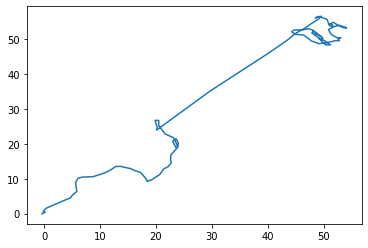

In [6]:
x_ns, t_ns = langevin_simu(delta_t)
plt.plot(x_ns[:,0], x_ns[:,2])

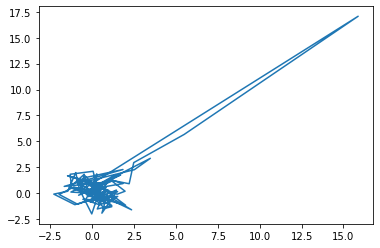

In [7]:
plt.plot(x_ns[:,1], x_ns[:,3])

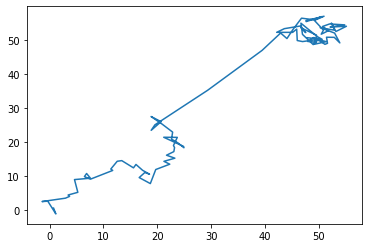

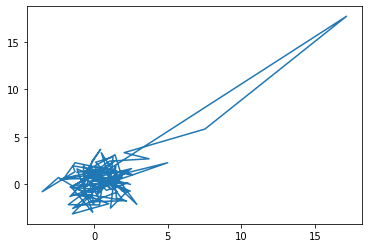

In [8]:
noise_sig = 1
noise = np.random.normal(0, noise_sig, (N, 4))
y_ns = x_ns+noise # noisy data
plt.figure()
plt.plot(y_ns[:,0], y_ns[:,2])
plt.figure()
plt.plot(y_ns[:,1], y_ns[:,3])

In [9]:
def single_ite_particle_filtering(y_n, log_weight_p, mu_p, P_p, delta_t, resample = False):
    # mu_p = [mu1, mu2, .. muP], P_p = [P1, P2, .. PP]
    num_particles = len(mu_p) # list of list of lists, because length if each particle is not fixed, P*n*I
    if resample:
        indices = np.random.choice(list(range(num_particles)), size = num_particles, p = np.exp(log_weight_p))
        mu_p = [mu_p[i] for i in indices]
        P_p = [P_p[i] for i in indices]
        
        log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))
    
    m12 = -(np.exp(-delta_t*l)-1)/l
    m22 = np.exp(-delta_t*l)
    F_delta_t = np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]])
    
    mu_p_nextn = []
    P_p_nextn = []
    log_weights_p_nextn = np.zeros(num_particles)
    for p in range(num_particles):
#         print(p)
        mean_Z, var_Z = TS_subordinator_jumps(delta_t) # generate jump mean and variance
    
        q12 = -1/(2*l**2)*(1-np.exp(-2*delta_t*l))+(1-np.exp(-delta_t*l))/l**2
        q22 = (1-np.exp(-2*delta_t*l))/(2*l)
        Q_delta_t = np.matrix([[0,q12,0,0],[0,q22,0,0],[0,0,0,q12],[0,0,0,q22]])
        S_delta_t = var_Z + (mu_w**2*M_z2+sigma_w**2*M_z1)*Q_delta_t

        m12 = -(np.exp(-delta_t*l)-1)/l
        m22 = np.exp(-delta_t*l)
        m_delta_t = np.matmul(np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]]),mu_p[p])
        
        m1 = -(1-np.exp(-delta_t*l))/l**2+delta_t/l
        m2 = (1-np.exp(-delta_t*l))/l
#         import pdb;pdb.set_trace()
        m_delta_t = m_delta_t+ np.matrix([m1, m2, m1, m2])*mu_w*M_z1 + mean_Z

        mu_n_prev_n = m_delta_t
        P_n_prev_n = F_delta_t*P_p[p]*F_delta_t.T + S_delta_t
        y_hat_n_prev_n = mu_n_prev_n
        sigma_n_prev_n = P_n_prev_n + np.identity(4)*noise_sig**2
        K = P_n_prev_n*np.linalg.inv(sigma_n_prev_n)
        mu_n_n = mu_n_prev_n+K*(y_n-y_hat_n_prev_n)
        P_n_n = (np.identity(4) - K)*P_n_prev_n
        
        mu_p_nextn.append(mu_n_n)
        P_p_nextn.append(P_n_n)

        log_w_p_nextn = log_weight_p[p]+np.log(stats.multivariate_normal(np.array(mu_n_n.T)[0], P_n_n).pdf(np.array(y_n.T)[0]))
        log_weights_p_nextn[p] = log_w_p_nextn
    
    # normalise weights
    log_weights_p_nextn = log_weights_p_nextn-np.log(sum(np.exp(log_weights_p_nextn)))
    
    return log_weights_p_nextn, mu_p_nextn, P_p_nextn

In [10]:
l = 1
# c = 20
N = 100
delta_t = 1
sigma_w = 0.2
mu_w = 0.01
alpha = 0.6 # 0.6
noise_sig = 0.1

# convert variables
C = alpha*2**alpha/(sf.gamma(1-alpha))
r = 2 # from generalised shot noise paper, 1.35
episilon = 1e-3
c = C*episilon**(-alpha)/alpha/delta_t
beta = 0.5*r**(1/alpha)

# calculate first/second moment of residuals
M_z1 = 2**(1-alpha)*r**(1-1/alpha)*C*sf.gamma(1-alpha)*sf.gammainc(1-alpha, 0.5*r**(1/alpha)*episilon)
M_z2 = C*sf.gamma(2-alpha)*2**(2-alpha)*r**(1-2/alpha)*sf.gammainc(2-alpha, 0.5*r**(1/alpha)*episilon)

In [17]:
n_mus = []
n_Ps = []
n_ws = []
num_particles = 1
for n in range(N):
#     print(n)
    # initialize x
    mu_p = [np.matrix([0,0,0,0]).T]*num_particles
    P_p = [np.matrix([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])*30]*num_particles
    log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))
    y_n = np.matrix(y_ns[n]).T
    log_weight_p, mu_p, P_p = single_ite_particle_filtering(y_n, log_weight_p, mu_p, P_p, delta_t,resample = True)
    
    n_mus.append(mu_p)
    n_Ps.append(P_p)
    n_ws.append(log_weight_p)

n_mus = np.array(n_mus)
n_Ps = np.array(n_Ps)
n_ws = np.exp(np.array(n_ws))

# mean of prediction
average = np.zeros((N, 4))
for i in range(N):
    for d in range(4):
        average[i,d]=np.dot(np.array(n_mus[i,:,d,:].T)[0], n_ws[i,:])
        



1.0291526952168255 1.0240653116142187


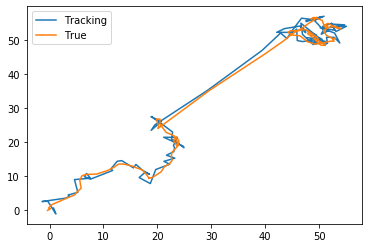

In [18]:
error = np.dot(average[:,0]-x_ns[:,0],average[:,0]-x_ns[:,0])/N
orig_error = np.dot(y_ns[:,0]-x_ns[:,0],y_ns[:,0]-x_ns[:,0])/N
print(error, orig_error)

plt.plot(average[:,0], average[:,2])
plt.plot(x_ns[:,0], x_ns[:,2])
# plt.plot(y_ns[:,0], y_ns[:,2])
plt.legend(['Tracking', 'True'])
# plt.legend(['Tracking', 'True', 'noisy'])

1.031452132694538


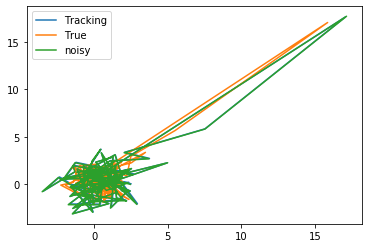

In [13]:
error = np.dot(average[:,1]-x_ns[:,1],average[:,1]-x_ns[:,1])/N
print(error)

plt.plot(average[:,1], average[:,3])
plt.plot(x_ns[:,1], x_ns[:,3])
plt.plot(y_ns[:,1], y_ns[:,3])
plt.legend(['Tracking', 'True', 'noisy'])
# plt.plot(x_ns[:,0], x_ns[:,2])